# Validation of Probiotic Growth Predictions
This notebook simulates the growth of MCMMs and validates the predicted probiotic growth rates for participants in Validation Study B

In [31]:
import pandas as pd
import numpy as np
import matplotlib.patches as mpatches
import micom
from plotnine import *
from sklearn.metrics import cohen_kappa_score
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

## Grab Metadata
Get the metadata provided on the NCBI SRA so we can identify samples

In [15]:
# Read Metadata 
metadata = pd.read_csv('../data/studyB_metadata.csv') 

# Split identifiers into separate columns
metadata[['cohort','subject_id']] = metadata['Cohort;_Subject_ID'].str.split(';', expand = True) 

# Isolate columns of interest
metadata_df = metadata[['Run','study_timepoint','cohort', 'subject_id']].rename(columns = {'Run':'sample_id'}) 

# Create subject dictionary
subject_dict = metadata_df.set_index('sample_id')['subject_id'].to_dict()

metadata.head()

,Run,Assay Type,AvgSpotLen,Bases,BioProject,BioSample,BioSampleModel,Bytes,Center Name,Cohort;_Subject_ID,...,Organism,Platform,ReleaseDate,create_date,version,Sample Name,SRA Study,study_timepoint,cohort,subject_id
0,SRR15520622,WGS,297,5049897739,PRJNA755324,SAMN20850613,Metagenome or environmental,2129667527,"VEDANTA BIOSCIENCES, INC.",Cohort 6; Subject 194,...,metagenome,ILLUMINA,2022-04-13T00:00:00Z,2021-08-20T15:15:00Z,4,S04508404100007,SRP333172,Week 6,Cohort 6,Subject 194
1,SRR15520623,WGS,296,6141031381,PRJNA755324,SAMN20850598,Metagenome or environmental,2565041147,"VEDANTA BIOSCIENCES, INC.",Cohort 6; Subject 192,...,metagenome,ILLUMINA,2022-04-13T00:00:00Z,2021-08-20T19:05:00Z,4,S04508304100007,SRP333172,Week 6,Cohort 6,Subject 192
2,SRR15520624,WGS,293,4566422143,PRJNA755324,SAMN20850300,Metagenome or environmental,2064779703,"VEDANTA BIOSCIENCES, INC.",Cohort Vanco; Subject 64,...,metagenome,ILLUMINA,2022-04-13T00:00:00Z,2021-08-21T01:23:00Z,3,S03893904100014,SRP333172,Screening,Cohort Vanco,Subject 64
3,SRR15520625,WGS,297,5440769358,PRJNA755324,SAMN20850583,Metagenome or environmental,2269104134,"VEDANTA BIOSCIENCES, INC.",Cohort 6; Subject 191,...,metagenome,ILLUMINA,2022-04-13T00:00:00Z,2021-08-21T01:28:00Z,3,S04508204100007,SRP333172,Week 6,Cohort 6,Subject 191
4,SRR15520626,WGS,298,24784975303,PRJNA755324,SAMN20850645,Metagenome or environmental,10734842350,"VEDANTA BIOSCIENCES, INC.",Cohort 6; Subject 203,...,metagenome,ILLUMINA,2022-04-13T00:00:00Z,2021-08-21T05:06:00Z,4,S04508104100006,SRP333172,Week 12,Cohort 6,Subject 203


# Load Sequencing Data
Load the species-level count Kraken2 output from MEDI, and merge with metadata

In [16]:
# Load sequencing data
s_counts = pd.read_csv('../data/studyB_S_counts.csv') 

# Match sample ID format to metadata
s_counts['sample_id'] = s_counts['sample_id'].str.replace(r'^S_', '', regex=True) 

# Merge with metadata 
s_counts = s_counts.merge(metadata_df, on='sample_id', how='left')

# Sort table
s_counts.sort_values(by = ['cohort','study_timepoint'], inplace = True)
s_counts.subject_id.nunique()

32

## Isolate Metagenomic Endpoint Measurements

In [26]:
# Isolate probiotic species 
counts_endpoint = s_counts[s_counts['name'].str.contains('|'.join(['Enterocloster bolteae', 'Anaerotruncus colihominis',
                                                                      'Sellimonas intestinalis', 'symbiosum', 
                                                                      'Dorea longicatena','Flavonifractor plautii']))]

# Identify cohorts of interest 
counts_endpoint = counts_endpoint[counts_endpoint['cohort'].str.contains('|'.join(['1','2','3','4','5']))]

# Rename columns
counts_endpoint.rename(columns = {'name':'species','fraction_total_reads':'abundance'}, inplace = True)

# Filter to timepoints of interest 
counts_endpoint = counts_endpoint[(counts_endpoint['study_timepoint'] == 'Week 12')|
    (counts_endpoint['study_timepoint'] == 'Day 0')][['species','abundance','study_timepoint','subject_id','cohort']]

# Pivot data 
counts_endpoint = pd.pivot_table(counts_endpoint, 
                                 index = ['subject_id','species', 'cohort'],
                                 columns = 'study_timepoint',
                                 values = 'abundance').fillna(0.0).reset_index()

# Drop sample missing follow-up
counts_endpoint = counts_endpoint[counts_endpoint['subject_id'] != ' Subject 102']
                                
# Identify threshold for engraftment 
threshold_ratio = 1.5

# Binarize engraftment by increase over threshold
counts_endpoint.loc[threshold_ratio*counts_endpoint['Day 0']>=counts_endpoint['Week 12'], 'engraftment'] = 0
counts_endpoint.loc[threshold_ratio*counts_endpoint['Day 0']<counts_endpoint['Week 12'], 'engraftment'] = 1

# No engraftment for abundance below 0.5%
counts_endpoint.loc[counts_endpoint['Week 12']<0.005, 'engraftment'] = 0

# Fix formating for C. symbiosum
counts_endpoint['species'] = counts_endpoint['species'].str.replace('[Clostridium]','Clostridium')

counts_endpoint

study_timepoint,subject_id,species,cohort,Day 0,Week 12,engraftment
0,Subject 100,Anaerotruncus colihominis,Cohort 3,0.00037,0.00184,0.0
1,Subject 100,Dorea longicatena,Cohort 3,0.00914,0.00009,0.0
2,Subject 100,Enterocloster bolteae,Cohort 3,0.00067,0.00092,0.0
3,Subject 100,Flavonifractor plautii,Cohort 3,0.00093,0.00498,0.0
4,Subject 100,Sellimonas intestinalis,Cohort 3,0.00000,0.00099,0.0
...,...,...,...,...,...,...
121,Subject 69,Dorea longicatena,Cohort 2,0.00771,0.00078,0.0
122,Subject 69,Enterocloster bolteae,Cohort 2,0.00021,0.07493,1.0
123,Subject 69,Flavonifractor plautii,Cohort 2,0.00149,0.00482,0.0
124,Subject 69,Sellimonas intestinalis,Cohort 2,0.00000,0.00309,0.0


## Prepare MCMM Medium
Load standard european medium as assumed background diet

In [18]:
# Load Medium 
eu_medium = pd.read_csv('../european_medium.csv')

## Grow Models
Simulate model growth with high tradeoff parameter

In [19]:
manifest_probiotic = pd.read_csv('../VE303_treated/manifest.csv')


growth = micom.workflows.grow(manifest_probiotic, 
                                  model_folder = '../VE303_treated/',
                                  medium = eu_medium,
                                  tradeoff = 0.99, 
                                  strategy = 'none',
                                  threads = 10)

Output()

## Collect Predicted Growth Rates
Isolate predictions for probiotic species a

In [27]:
# Gather growth rates
rates_probiotic = growth.growth_rates

# Isolate probiotics

rates_probiotic = rates_probiotic[rates_probiotic.index.isin(['Enterocloster_bolteae', 
                                                              'Anaerotruncus_colihominis',
                                                              'Sellimonas_intestinalis', 
                                                              'Dorea_longicatena', 
                                                              'Clostridium_symbiosum', 
                                                              'Flavonifractor_plautii',
                                                             ])].reset_index()
# Log scale growth rates
rates_probiotic['growth_rate_scaled'] = np.log10(rates_probiotic[['growth_rate']])

# Threshold log-scaled growth rates
rates_probiotic.loc[rates_probiotic['growth_rate_scaled']>=-2, 'MCMM_engraftment'] = 1
rates_probiotic.loc[rates_probiotic['growth_rate_scaled']<-2, 'MCMM_engraftment'] = 0

# Reformat Names 
rates_probiotic['compartments'] = rates_probiotic['compartments'].str.replace('_Clostridium_', 'Clostridium')
rates_probiotic['compartments'] = rates_probiotic['compartments'].str.replace('_',' ')

rates_probiotic

/users/nbohmann/miniconda3/envs/micom2024/lib/python3.9/site-packages/pandas/core/internals/blocks.py:395: RuntimeWarning: divide by zero encountered in log10


,compartments,abundance,growth_rate,reactions,metabolites,taxon,tradeoff,sample_id,growth_rate_scaled,MCMM_engraftment
0,Anaerotruncus colihominis,0.166667,2.127080e-02,1209,1066,Anaerotruncus_colihominis,0.99,Subject 110,-1.672216,1.0
1,Clostridium symbiosum,0.166667,1.204628e-02,1442,1249,Clostridium_symbiosum,0.99,Subject 110,-1.919147,1.0
2,Dorea longicatena,0.166667,2.219644e-02,1647,1326,Dorea_longicatena,0.99,Subject 110,-1.653717,1.0
3,Enterocloster bolteae,0.166667,2.029811e-02,2087,1874,Enterocloster_bolteae,0.99,Subject 110,-1.692544,1.0
4,Flavonifractor plautii,0.166667,1.786756e-02,1355,1191,Flavonifractor_plautii,0.99,Subject 110,-1.747935,1.0
...,...,...,...,...,...,...,...,...,...,...
115,Clostridium symbiosum,0.166480,3.324776e-02,1442,1249,Clostridium_symbiosum,0.99,Subject 55,-1.478238,1.0
116,Dorea longicatena,0.166480,4.875970e-14,1647,1326,Dorea_longicatena,0.99,Subject 55,-13.311939,0.0
117,Enterocloster bolteae,0.166480,2.254269e-02,2087,1874,Enterocloster_bolteae,0.99,Subject 55,-1.646994,1.0
118,Flavonifractor plautii,0.166480,5.077533e-16,1355,1191,Flavonifractor_plautii,0.99,Subject 55,-15.294347,0.0


## Create Agreement Heatmap
Find agreement between predictions and measures

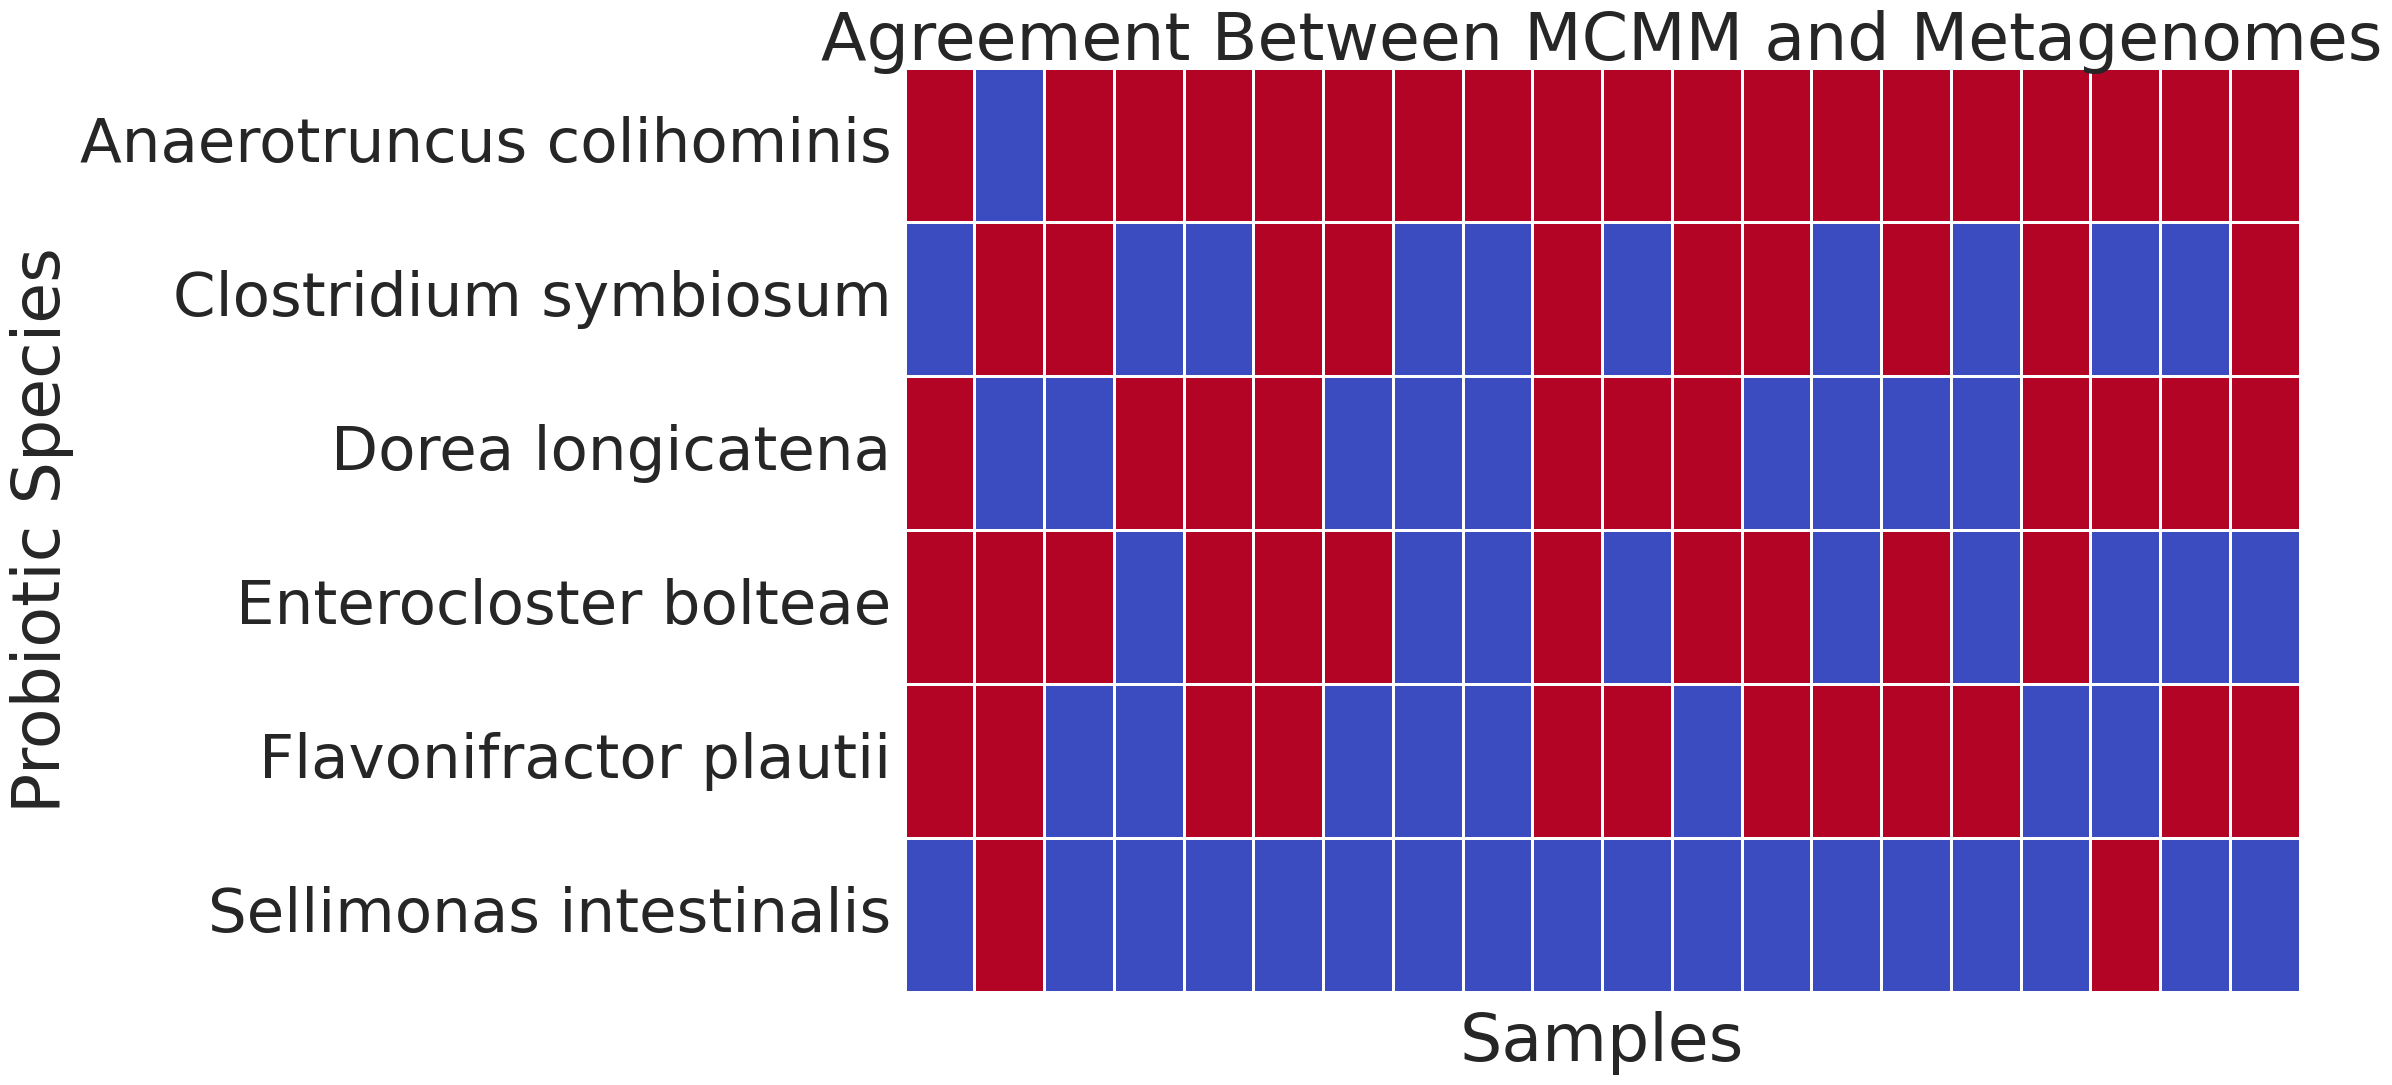

In [29]:
# Create Metagenome Engraftment Pivot Table
df1 = pd.pivot_table(counts_endpoint, 
                    index='species',
                    columns='subject_id',
                    values='engraftment').fillna(0.0)

# Create MCMM Engraftment Pivot Table
df2 = pd.pivot_table(rates_probiotic, 
                    index='compartments',
                    columns='sample_id',
                    values='MCMM_engraftment').fillna(0.0)

# Ensure both dataframes are numeric (convert from strings if necessary)
df1 = df1.astype(float)
df2 = df2.astype(float)

# Calculate agreement matrix
agreement_matrix = (df1 == df2).astype(int)
agreement_matrix.index.name = 'Probiotic Species'
agreement_matrix.columns.name = 'Samples'
agreement_matrix.index = agreement_matrix.index.str.replace('_', ' ')
# Plot heatmap of agreement
plt.figure(figsize=(18, 12))
sns.set(font_scale=4) 
ax = sns.heatmap(agreement_matrix, cmap='coolwarm_r',
                 annot=False, cbar=False, square=False, 
                 linewidths=1, linecolor='white')
ax.set_xticklabels([])
plt.title('Agreement Between MCMM and Metagenomes')
plt.savefig('../figures/agreement_heatmap_studyB.svg', dpi=300, bbox_inches='tight')  # Save as PNG with 300 DPI

## Calculate Cohen's Kappa
Measure the agreement 

In [32]:
# Flatten predictions and measures
ratings1 = df1.values.flatten()
ratings2 = df2.values.flatten()

# Compute Cohen's kappa
kappa = cohen_kappa_score(ratings1, ratings2)

print(f"Cohen's kappa: {kappa:.4f}")

Cohen's kappa: -0.1194


## Calculate % Agreement
Calculate agreement as a percentage

In [33]:
agree_ones = agreement_matrix.sum().sum()
growth_ones = df2.sum().sum()
total = agreement_matrix.size
print(str((agree_ones/total).round(4)*100)+'%')

45.83%


## Plot Confusion Matricies

In [ ]:
strains = df1.index

FONTS = {
    "suptitle": 32,
    "title": 28,
    "axis_labels": 28,
    "tick_labels": 25,
    "heatmap_annotations": 28
}

sns.set(style="whitegrid", font_scale=FONTS["tick_labels"]/10)  # scale factor for seaborn
# Set up subplot grid
fig, axes = plt.subplots(3,3, figsize=(18, 18))
axes = axes.flatten()  # Flatten for easy iteration



# Define consistent color limits
vmin, vmax = 0, 20

# Aggregate all results
all_y_true = df1.values.flatten()  # Flatten across all strains
all_y_pred = df2.values.flatten()

# Compute overall confusion matrix
cm_agg = sklearn.metrics.confusion_matrix(all_y_true, all_y_pred)

# Ensure correct shape for formatting
if cm_agg.shape == (1, 1):
    cm_agg = np.array([[cm_agg[0, 0], 0], [0, 0]])

# Plot aggregated confusion matrix
sns.heatmap(cm_agg, annot=True, fmt="d", cmap="Reds",
            xticklabels=["No Growth", "Growth"],
            yticklabels=["No Growth", "Growth"],
            ax=axes[0],
            vmin=vmin*6, vmax=vmax*6,
            annot_kws={"fontsize": FONTS["heatmap_annotations"]})

ax = axes[0]
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_yticklabels(ax.get_yticklabels(), rotation=90)
# Loop through each strain
for i, strain in enumerate(strains):
    print(strain)
    y_true = df1.loc[strain].values.flatten()
    y_pred = df2.loc[strain].values.flatten()

    cm = sklearn.metrics.confusion_matrix(y_true, y_pred)

    if cm.shape == (1, 1):
        cm = np.array([[cm[0, 0], 0], [0, 0]])

    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["No Growth", "Growth"],
                yticklabels=["No Growth", "Growth"],
                ax=axes[i+1],
                vmin=vmin, vmax=vmax,
                annot_kws={"fontsize": FONTS["heatmap_annotations"]})
    ax = axes[i+1]
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=90)
fig.delaxes(axes[-1])
fig.delaxes(axes[-2])

axes[0].set_title("Aggregate \n Across Strains", fontsize=FONTS["title"])
axes[1].set_title('Anaerotruncus \n colihominis', fontsize=FONTS["title"])
axes[2].set_title('Dorea \n longicatena', fontsize=FONTS["title"])
axes[3].set_title('Enterocloster \n bolteae', fontsize=FONTS["title"])
axes[4].set_title('Flavonifractor \n plautii', fontsize=FONTS["title"])
axes[5].set_title('Sellimonas \n intestinalis', fontsize=FONTS["title"])
axes[6].set_title('Clostridium \n symbiosum', fontsize=FONTS["title"])
fig.suptitle("Confusion Matrices of Model Predictions vs. Metagenomes", fontsize=FONTS["suptitle"])
fig.text(-0.02, 0.5, "Model Prediction", va='center', rotation='vertical', fontsize=FONTS["axis_labels"])
fig.text(0.5, -0.02, "Metagenomic Ground Truth", ha='center', fontsize=FONTS["axis_labels"])


plt.tight_layout()
plt.savefig('../confusion_matricies_studyB.svg', dpi=300, bbox_inches='tight')  # Save as PNG with 300 DPI
plt.show()


Anaerotruncus colihominis
Clostridium symbiosum
Dorea longicatena
Enterocloster bolteae
Flavonifractor plautii
Sellimonas intestinalis


## Calculate Fisher's Exact Test for Aggregate Result


In [ ]:
scipy.stats.fisher_exact(cm_agg)

## Sensitivity Analysis
Test how growth rates thresholds impact prediction accuracy

In [ ]:
for threshold in np.logspace(-5, 0.7, num=50):
        # Threshold log-scaled growth rates
        rates_probiotic.loc[rates_probiotic['growth_rate']>=threshold, 'MCMM_engraftment'] = 1
        rates_probiotic.loc[rates_probiotic['growth_rate']<threshold, 'MCMM_engraftment'] = 0
        
        
        # Create MCMM Engraftment Pivot Table
        df2 = pd.pivot_table(rates_probiotic, 
                            index='compartments',
                            columns='sample_id',
                            values='MCMM_engraftment').fillna(0.0)
        df2.index = df2.index.str.replace('_Clostridium_','Clostridium')
        # Ensure both dataframes are numeric (convert from strings if necessary)
        df2 = df2.astype(float)
        df2 = df2[df1.columns]
    
        # Calculate agreement matrix
    
        agreement_matrix = (df1 == df2).astype(int)
        
        ratings1 = df1.values.flatten()
        ratings2 = df2.values.flatten()
        
        # Compute Cohen's kappa
        kappa = sklearn.metrics.cohen_kappa_score(ratings1, ratings2)
        
        agree_ones = agreement_matrix.sum().sum()
        growth_ones = df2.sum().sum()
        total = agreement_matrix.size
        
        cm = confusion_matrix(ratings1, ratings2)
        
        if cm.shape == (1, 1):
            cm = np.array([[cm[0, 0], 0], [0, 0]])
        fisher = scipy.stats.fisher_exact(cm)
        res = pd.concat([res, pd.DataFrame({'agreement':[(agree_ones/total)],
                                            'kappa':[kappa],
                                            'fisher':[fisher[1]],
                                            'threshold':[threshold]
                                           }
                                          )
                        ]
                       )
# Convert results into long format 
res_long = res.melt(id_vars='threshold', value_vars=['agreement', 'kappa'],
                    var_name='metric', value_name='value')

## Plot Sensitivity 

In [ ]:
sensitivity_plot = (ggplot(res_long, aes(x='threshold', y='value', color='metric'))
                    + geom_line(size=1.2)
                    + scale_x_log10()
                    +geom_vline(xintercept = 0.01)
                    + labs(y='Value', x='Growth Rate Threshold', color='Metric')
                    +scale_color_discrete(limits = ['agreement','kappa'], labels = ['Percent Agreement','Cohens Kappa'])
                    + theme_minimal()
                   )

ggsave(sensitivity_plot, '../figures/sensitivity_studyB.svg',dpi = 200)
sensitivity_plot